In [2]:
using Pkg
Pkg.activate(".")
# Pkg.instantiate()
using YAXArrays
using Zarr
using Dates

  Activating project at `~/workspace/uni/spatial_temporal_data/spatio_temporal_data-rainforest_development`


In [30]:
include("./rainforest_lib.jl")
using .RainforestLib

In [31]:
lc = RainforestLib.get_lcc_datacube()


YAXArray with the following dimensions
lon                 Axis with 129600 Elements from -179.9986111111111 to 179.99861111111113
lat                 Axis with 64800 Elements from 89.99861111111113 to -89.99861111111112
time                Axis with 11 Elements from 2010-01-01T00:00:00 to 2020-01-01T00:00:00
name: lccs_class
Total size: 86.03 GB


In [32]:
filtered_dc = RainforestLib.rough_spatial_filter(lc)


YAXArray with the following dimensions
lon                 Axis with 21600 Elements from -89.9986111111111 to -30.001388888888876
lat                 Axis with 16200 Elements from 14.99861111111112 to -29.99861111111111
time                Axis with 2 Elements from 2010-01-01T00:00:00 to 2011-01-01T00:00:00
name: lccs_class
Total size: 667.42 MB


In [33]:
local_dc = filtered_dc[:,:, 1]

21600×16200 Matrix{UInt8}:
 0x28  0x28  0x28  0x6e  0x6e  0x64  …  0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x32  0x28  0x28  0x64  0x32  0x32     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x28  0x78  0x78  0x78  0x64  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x28  0x28  0x32  0x64  0x28  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x28  0x32  0x32  0x64  0x28  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x28  0x32  0x32  0x32  0x28  0x28  …  0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x28  0x64  0x64  0x28  0x78  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x32  0x32  0x32  0x28  0x78  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x32  0x64  0x32  0x28  0x78  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0x32  0x64  0x64  0x28  0x28  0x28     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
    ⋮                             ⋮  ⋱           ⋮                    
 0xd2  0xd2  0xd2  0xd2  0xd2  0xd2     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0xd2  0xd2  0xd2  0xd2  0xd2  0xd2     0xd2  0xd2  0xd2  0xd2  0xd2  0xd2
 0

In [46]:
using .RainforestLib
bitmask = local_dc .== RainforestLib.get_lccs_flag("tree_broadleaved_evergreen_closed_to_open")
new_bitmask = map(bitmask) do x
    if x == 0
        NaN32
    else
        Float32(1)
        
    end
end
new_bitmask[:] .= 1
#new_bitmask = new_bitmask[:, end:-1:1]

349920000-element view(::Vector{Float32}, :) with eltype Float32:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

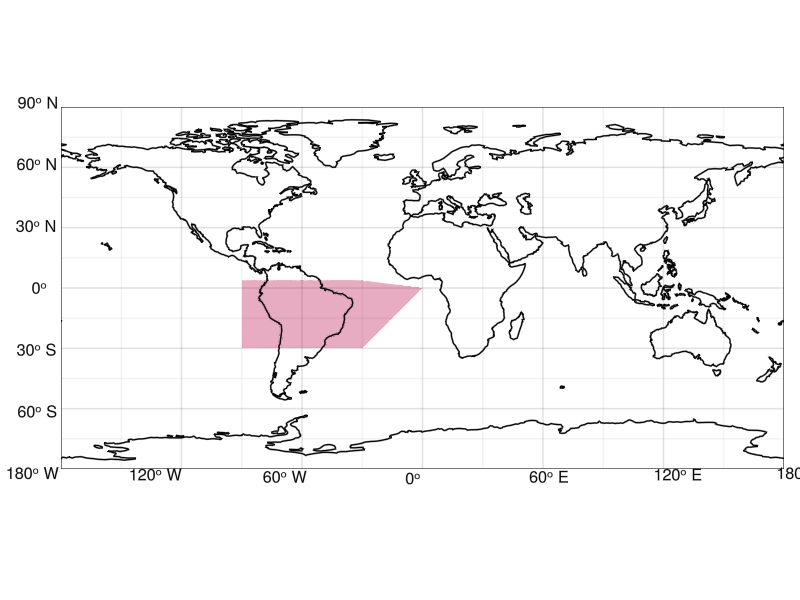

In [71]:
using GeoMakie, GLMakie

lon = YAXArrays.getAxis("lon", filtered_dc).values |> extrema
lat = YAXArrays.getAxis("lat", filtered_dc).values |> extrema
lonrange = range(lon[1], lon[end], size(new_bitmask, 2))
latrange = range(lat[1], lat[end], size(new_bitmask, 1))

fig = Figure()
dest = "+proj=lonlat"
ga = GeoMakie.GeoAxis(
    fig[1, 1]; # any cell of the figure's layout
    dest = dest,
    source = dest,
    coastlines = true # plot coastlines from Natural Earth, as a reference.
)

surface!(ga, lonrange, latrange, new_bitmask; shading = false, colormap = (:plasma, 0.45))

fig